In [1]:
import numpy as np
from music21 import *
import glob
import sys
import math
from tensorflow.keras.models import Sequential, Model, load_model
sys.path.append("../RL modules/")
from env_noOctave import SegmentationEnv
import matplotlib.pyplot as plt

In [3]:
base_lr = 0.001
max_lr = 0.1
step_size = 8
def masterScheduler(epoch):
    def scheduler():
            period = 2 * step_size
            cycle = math.floor(1 + epoch/period)
            x = abs(epoch/step_size - 2*cycle + 1)
            delta = (max_lr - base_lr)*max(0, (1 - x))
            delta /= float(2 ** (cycle - 1))
            return base_lr + delta
    return scheduler

Text(0.5, 1.0, 'LR schedule')

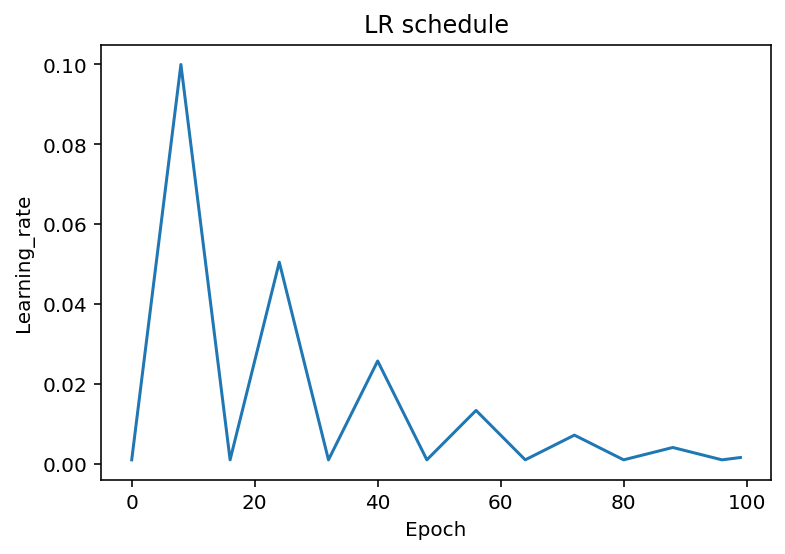

In [7]:
lr_schedule = []
for i in range(100):
    lr_schedule.append(masterScheduler(i)())
plt.plot(lr_schedule)
plt.xlabel("Epoch")
plt.ylabel("Learning_rate")
plt.title("LR schedule")

In [5]:
testing_pieces = []
for piece in glob.glob('./normal/training/*'):
    testing_pieces.append(piece)

for piece in glob.glob('./C_normalized/testing/*'):
    testing_pieces.append(piece)

In [6]:
testing_pieces 

['./normal/training\\Fugue_in_G_Minor.mxl',
 './normal/training\\G_minor.mxl',
 './normal/training\\Menuet_in_G_Minor.mxl',
 './normal/training\\Minuet_in_F.mxl',
 './normal/training\\Minuet_in_G_Major.mxl',
 './normal/training\\Moonlight_Sonata_1st_Movement.mxl',
 './normal/training\\Musette_in_D.mxl',
 './normal/training\\Nocturne_in_B_Major.mxl',
 './normal/training\\Nocturne_in_C#_Minor.mxl',
 './normal/training\\Nocturne_in_Eb_Major.mxl',
 './normal/training\\Nocturne_in_E_Minor.mxl',
 './normal/training\\Nocturne_in_F#_Major.mxl',
 './normal/training\\Nocturne_in_F_Minor.mxl',
 './normal/training\\Nocturne_no._1.mxl',
 './normal/training\\Nocturne_No._20_in_C#_Minor.mxl',
 './normal/training\\Prélude_in_A_Major.mxl',
 './normal/training\\Prélude_in_B_Major.mxl',
 './normal/training\\Prélude_in_B_Minor.mxl',
 './normal/training\\Prélude_in_B_Minor_op104a.mxl',
 './normal/training\\Prélude_in_Db_Major.mxl',
 './normal/training\\Prélude_in_E_Minor.mxl',
 './normal/training\\Prélude_

In [7]:
model = load_model("dqn_normalized_2")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 48)                1248      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 2,474
Trainable params: 2,474
Non-trainable params: 0
_________________________________________________________________


In [8]:
env = SegmentationEnv(testing_pieces)

start
change key
change key
change key
change key
change key
change key
change key
change key
./normal/training\Fugue_in_G_Minor.mxl
start
change key
./normal/training\G_minor.mxl
start
change key
change key
change key
change key
./normal/training\Menuet_in_G_Minor.mxl
start
change key
change key
./normal/training\Minuet_in_F.mxl
start
change key
change key
./normal/training\Minuet_in_G_Major.mxl
start
change key
change key
change key
change key
change key
change key
change key
./normal/training\Moonlight_Sonata_1st_Movement.mxl
start
change key
change key
./normal/training\Musette_in_D.mxl
start
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
./normal/training\Nocturne_in_B_Major.mxl
start
change key
change key
change key
change key
change key
change key
change key
change key
./normal/training\Nocturne_in_C#_Minor.mxl
start
change key
change key
change key
./normal/training\Nocturne_in_Eb_Major.mxl
sta

In [14]:
def Visualization(piece,offset): #offset assume sorted.
    def cal_offset(e):
        if e is None:
            return 0
        return e.offset + cal_offset(e.activeSite)
    c = converter.parse(piece)
    # partStream = c.parts.stream()
    # post = c.flattenParts().flat
    all_notes = []
    # for note in post.notes:
    #     print(note,note.offset,note.lyric)
    for el in c.recurse().notes:
        if el.lyric is not None:
            el.lyric = el.lyric.replace("♭", "b")
        all_notes.append([el.lyric, el, cal_offset(el),el.duration.linked])
    b = sorted(all_notes, key=lambda x: x[0] if x[0] is not None else "ZZZ")
    b = sorted(b, key=lambda x: x[-2])
    # print(b)
    for e in b:
        if len(offset) >0 and float(round(e[2],1)) >= offset[0] and e[3]:
            del offset[0]
            e[1].addLyric("CUT")
    GEX = musicxml.m21ToXml.GeneralObjectExporter(c)
    out = GEX.parse()
    piecename = piece.split("\\")[-1]
    piecename = piecename.split(".")[0]
    piecename = "LSTMVis_"+piecename + ".musicxml"
    print(piece,piecename)
    with open(piecename, "wb") as f:
        f.write(out)

In [9]:
def getoffset(offsets,segments):
    off = []
    for i in range(len(offsets)):
        if segments[i]:
            off.append(offsets[i])
    return off,offsets[-1]

In [ ]:
###NORMAL
from dhd import segmentation_quality
sqs = []
fmea = []
for i in range(len(env.notes)):
    offsets = []
    obs = env.reset(i)
    total_reward = 0
    max_reward = 0
    num_correct_segment = 0
    tp,tn,fp,fn = 0,0,0,0
    while True:
        obs = obs.reshape((1, 12*2+1))
        action = np.argmax(model.predict(obs))
        if action == 1:
            offsets.append(env.current_noteoffset)
        obs, reward, done, info = env.step(action)
        #env.render()
        total_reward += reward
        max_reward += 1
        if reward ==1 and action == 1:
            num_correct_segment += 1
            tp += 1
        elif reward == 1 and action == 0:
            tn += 1
        elif action == 1:
            fp += 1
        else:
            fn += 1
        if done:
            break
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fm = 2*precision*recall/(precision+recall)
    gtoffsets,foffset = getoffset(env.offset[i],env.is_segment[i])
    off = [(0, offsets[0])]
    for k in range(1, len(offsets)):
        off.append((offsets[k - 1], offsets[k]))
    off.append((offsets[-1], foffset))
    gtoff = [(0, gtoffsets[0])]
    for k in range(1, len(gtoffsets)):
        gtoff.append((gtoffsets[k - 1], gtoffsets[k]))
    gtoff.append((gtoffsets[-1], foffset))
    sq = segmentation_quality(off,gtoff)
    print(f"Piece {testing_pieces[i]}, total reward = {total_reward}/{max_reward}, f-measure = {fm}, sq = {sq}")
    fmea.append(fm)
    sqs.append(sq)
    


Piece ./normal/training\Fugue_in_G_Minor.mxl, total reward = 99/269, f-measure = 0.7564469914040114, sq = 0.7658582089552239
Piece ./normal/training\G_minor.mxl, total reward = 95/261, f-measure = 0.5363128491620112, sq = 0.7038461538461538
Piece ./normal/training\Menuet_in_G_Minor.mxl, total reward = 40/94, f-measure = 0.6301369863013699, sq = 0.7978723404255319
Piece ./normal/training\Minuet_in_F.mxl, total reward = 21/71, f-measure = 0.41860465116279066, sq = 0.676056338028169
Piece ./normal/training\Minuet_in_G_Major.mxl, total reward = 46/120, f-measure = 0.5316455696202532, sq = 0.73109243697479
Piece ./normal/training\Moonlight_Sonata_1st_Movement.mxl, total reward = 55/137, f-measure = 0.760233918128655, sq = 0.8272058823529411
Piece ./normal/training\Musette_in_D.mxl, total reward = 22/56, f-measure = 0.10526315789473682, sq = 0.5818181818181818
Piece ./normal/training\Nocturne_in_B_Major.mxl, total reward = 176/384, f-measure = 0.6749999999999999, sq = 0.8038000409193208


In [ ]:
###LSTM Version
for i in range(len(env.notes)):
    offsets = []
    obs = env.reset(i)
    total_reward = 0
    max_reward = 0
    num_correct_segment = 0
    state_data = []
    for j in range(10 - 1):
        state_data.append(np.append(np.zeros((12 * 2 + 1,)), -1))
    state_data.append(np.append(obs, -1))
    while True:
        state_datax = np.array(state_data)
        state_datax = state_datax.reshape((1, 10, 2 * 12 + 1 + 1))
        action = np.argmax(model.predict(state_datax))
        if action == 1:
            offsets.append(env.current_noteoffset)
        obs, reward, done, info = env.step(action)
        #env.render()
        del state_data[0]
        state_data[-1][-1] = action
        state_data.append(np.append(obs, -1))
        total_reward += reward
        max_reward += 1
        if reward ==1 and action == 1:
            num_correct_segment += 1
        if done:
            break
    print(f"Piece {testing_pieces[i]}, total reward = {total_reward}/{max_reward}, correct segment = {num_correct_segment}")
    offsets = [float(round(offset,1)) for offset in offsets]
    print(offsets)
    try:
        Visualization(env.piecelist[i],offsets)
    except:
        print("ERROR IN PIECE.")

Piece ./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml, total reward = 90/410, correct segment = 0
[]
./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml LSTMVis_Debussy_Arabesque_No.musicxml
Piece ./normal/testing\Il_Vecchio_Castello.mxl, total reward = 25/211, correct segment = 0
[]
./normal/testing\Il_Vecchio_Castello.mxl LSTMVis_Il_Vecchio_Castello.musicxml
Piece ./normal/testing\not1_Prelude_I.musicxml, total reward = 42/238, correct segment = 0
[]
./normal/testing\Piano_Sonata_No._11.mxl LSTMVis_Piano_Sonata_No.musicxml
Piece ./normal/testing\Piano_Sonata_No._11.mxl, total reward = -45/49, correct segment = 0
[]
./normal/testing\Prélude_in_C_Minor.mxl LSTMVis_Prélude_in_C_Minor.musicxml
Piece ./normal/testing\Prélude_in_C_Minor.mxl, total reward = 232/608, correct segment = 0
[]
ERROR IN PIECE.


In [19]:
testing_pieces

['./normal/testing\\Debussy_Arabesque_No._1_in_E_Major.musicxml',
 './normal/testing\\Il_Vecchio_Castello.mxl',
 './normal/testing\\not1_Prelude_I.musicxml',
 './normal/testing\\Piano_Sonata_No._11.mxl',
 './normal/testing\\Prélude_in_C_Minor.mxl',
 './normal/testing\\Waltz_in_A_Minor.mxl',
 './normal/testing\\Étude_in_C_Minor.mxl']